[Open in colab](https://colab.research.google.com/drive/1FKs5QZomQJAsCiN1oX0rean-_9BMyqnT?usp=sharing)

# scCoral - Simulated data

In this notebook, we will follow the basic workflow of scCoral using a simulated dataset.

<div align="center">
<img src="https://raw.githubusercontent.com/lucas-diedrich/sccoral/main/docs/_static/img/logo.png" alt="scCoral Logo" width="100">
</div>

---
**Before you start**

We highly recommend you to activate GPU usage in your google-colab environment to speed up training. Using a GPU during traing speeds up model fitting by ~1 order of magnitude

> Go to *Runtime > Change runtime type > Hardware Accelerator=T4 GPU*

---



## Overview of the full scCoral workflow

We use scCoral similarly to other factor models and conduct standard quality control and preprocessing steps on the dataset in advance. Overall, the workflow contains several stages:


### Preprocessing

1. **Quality control**
This step might depend on the dataset. Generally, we follow current best practices in the field, see Heumos et al, 2023 [^Heumos2023]


2. **Highly variable gene selection.** We perform feature selection on the raw counts using the implementation by Stuart et al, 2019 [^Stuart2019]. The exact number of highly variable genes might vary between datasets. For real data, we consider all overdispersed genes (`norm_variance>1` for HVG selection implementation by Stuart 2019 `flavor=seurat_v3`)


### Parameter selection

3. **Dimensionality selection** We select the number of modelled "free" latent factors based on the knee of a scree plot, using the kneedle algorithm [^Satopaa2011]. We implemented this method in sccoral with the method `sccoral.tl.select_dimensionality`

4. **Covariate selection** The selection of the modelled known conditions depends on the exact biological question and experimental setup. We use principal component regression [^Sikkema2023] (`sccoral.tl.stats.principal_component_regression`) to approximate the explained variance by a  covariate that is of potential interest. We use this proxy to assess whether modelling the covariate is useful. Empirically, we found that covariates that explain ~1% of variance in the data can be recovered well by the model.

5. **Tuning** We run scCoral with different regularization strenghts on a subsampled subset of the data (~10 000 cells) to select the optimal regularization strength. In our experiments, the ideal parameter was usually in the range between 10 and 1000 and we conducted hyperparameter sweeps in the range $0, 1, 10, 50, 100, 500, 1000, 10000$


### Run

6. **Model run** We run the model on the highly variable genes (raw counts), with optimal regularization strength and dimensionality as well as covariates of interest.


### Evaluation

7.  **Evaluation** We obtain the factor activities and gene loadings from the model with `model.get_latent_representation` and `model.get_loadings`, respectively.

## Tutorial

### Setup

Let's first install all necessary dependencies, load the modules, and define some helper functions.

`sccoral` can be readily installed via the `pip` package manager.

In [ ]:
# Verbose output
! pip install git+https://github.com/lucas-diedrich/sccoral.git@main --force-reinstall
! pip install scanpy[scikit-misk]
! pip install kneed

In [ ]:
import sccoral
import sccoral.tl

# To set a manual seed
import scvi
import torch

# Data loading/Plotting
import scanpy as sc

# Evaluation
import numpy as np
import pandas as pd
import scipy.spatial.distance as scd

from scipy.optimize import linear_sum_assignment as lsa
from scipy import stats

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
sc.settings.set_figure_params(dpi=75)

In [ ]:
def compute_cosine_similarity(loadings: pd.DataFrame,
                              ground_truth: pd.DataFrame
                              ) -> pd.DataFrame:
  """ Compute cosine similarity between inferred gene loadings (genes x factors)
  and ground truth (genes x factors)"""

  # Compute pairwise cosine similarity (1-cosine distance)
  similarity = 1-scd.cdist(
    adata.varm['program_loading'].T,
    loadings.T,
    metric='cosine'
    ).T

  # Compute optimal ordering
  _, idx = lsa(similarity.T, maximize=True)

  # Sort
  similarity = (
      pd.DataFrame(similarity, index=loadings.columns, columns=ground_truth.columns)
      .iloc[idx, :]
      )

  return similarity

### Load + inspect data

First, we load the data. Usually, we would perform quality control and highly variable gene selection in advance. As we are using simulated data in this tutorial, we can skip this step.

We load the sccoral build-in dataset with the `sccoral.data` functionality.

The simulated data is supposed to represent a collection of five subpopulations whose gene expression is further influenced by their sample identity.

In [ ]:
adata = sccoral.data.splatter_simulation()

In [ ]:
# @markdown
adata.obs['sample_id'] = adata.obs['sample_id'].astype('category')
adata.obs['categorical_covariate'] = adata.obs['categorical_covariate'].astype('category')

np.random.seed(42)
random_mapping = {sample: np.random.randint(2) for sample in adata.obs['sample_id'].unique()}
adata.obs['random_covariate'] = adata.obs['sample_id'].apply(lambda k: random_mapping[k])
adata.obs['cell_identity'] = pd.Series((adata.obsm["program_usage"][:, :5] * np.arange(1, 6)).sum(axis=1), index=adata.obs_names).astype('category')

In [ ]:
adata

AnnData object with n_obs × n_vars = 4000 × 5000
    obs: 'sample_id', 'categorical_covariate', 'continuous_covariate', 'random_covariate', 'cell_identity'
    var: 'mean', 'std'
    uns: 'log1p', 'neighbors', 'pca', 'simulation_param', 'umap'
    obsm: 'X_pca', 'X_umap', 'program_usage'
    varm: 'PCs', 'program_loading'
    layers: 'counts', 'scaled'
    obsp: 'connectivities', 'distances'

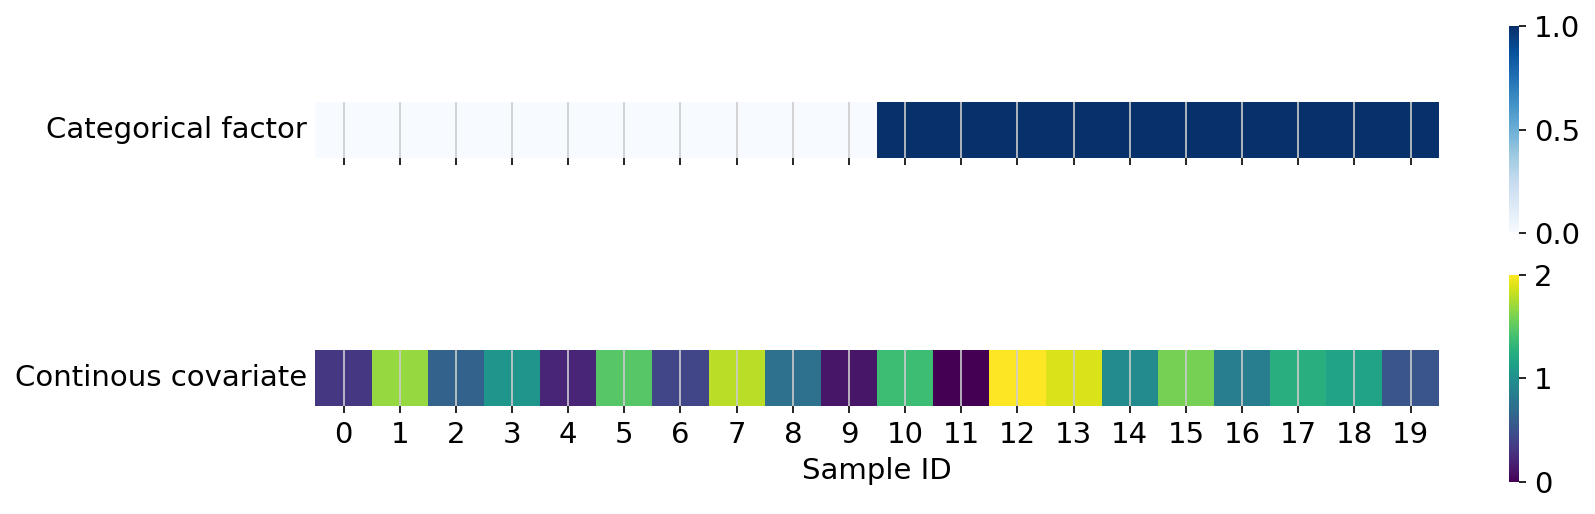

In [ ]:
# @markdown Here, we show the sample structure of the dataset. We note that the 20 simulated samples were assigned to two different levels of a categorical factor
# @markdown Further, the samples are associated with a continuous covariate, whose strength varies between samples.
# @markdown Based on this metadata, we modified the gene expression in the simulated cell population so that it is correlated with the sample-level information.
sample_level_metadata = adata.obs.groupby('sample_id').agg({'categorical_covariate': 'first', 'continuous_covariate': 'first'})

fig, axs = plt.subplots(2, 1, figsize=(12, 4), sharex=True)
sns.heatmap(sample_level_metadata[['categorical_covariate']].astype(int).T, cmap='Blues', square=True, ax=axs[0])
sns.heatmap(sample_level_metadata[['continuous_covariate']].T, cmap='viridis', square=True, ax=axs[1])

axs[0].set(xlabel='', yticks=[])
axs[1].set(xlabel='Sample ID', ylabel='Continous covariate', yticks=[])

axs[0].set_ylabel('Categorical factor', rotation=0, ha='right', va='center')
axs[1].set_ylabel('Continous covariate', rotation=0, ha='right', va='center')


plt.show()

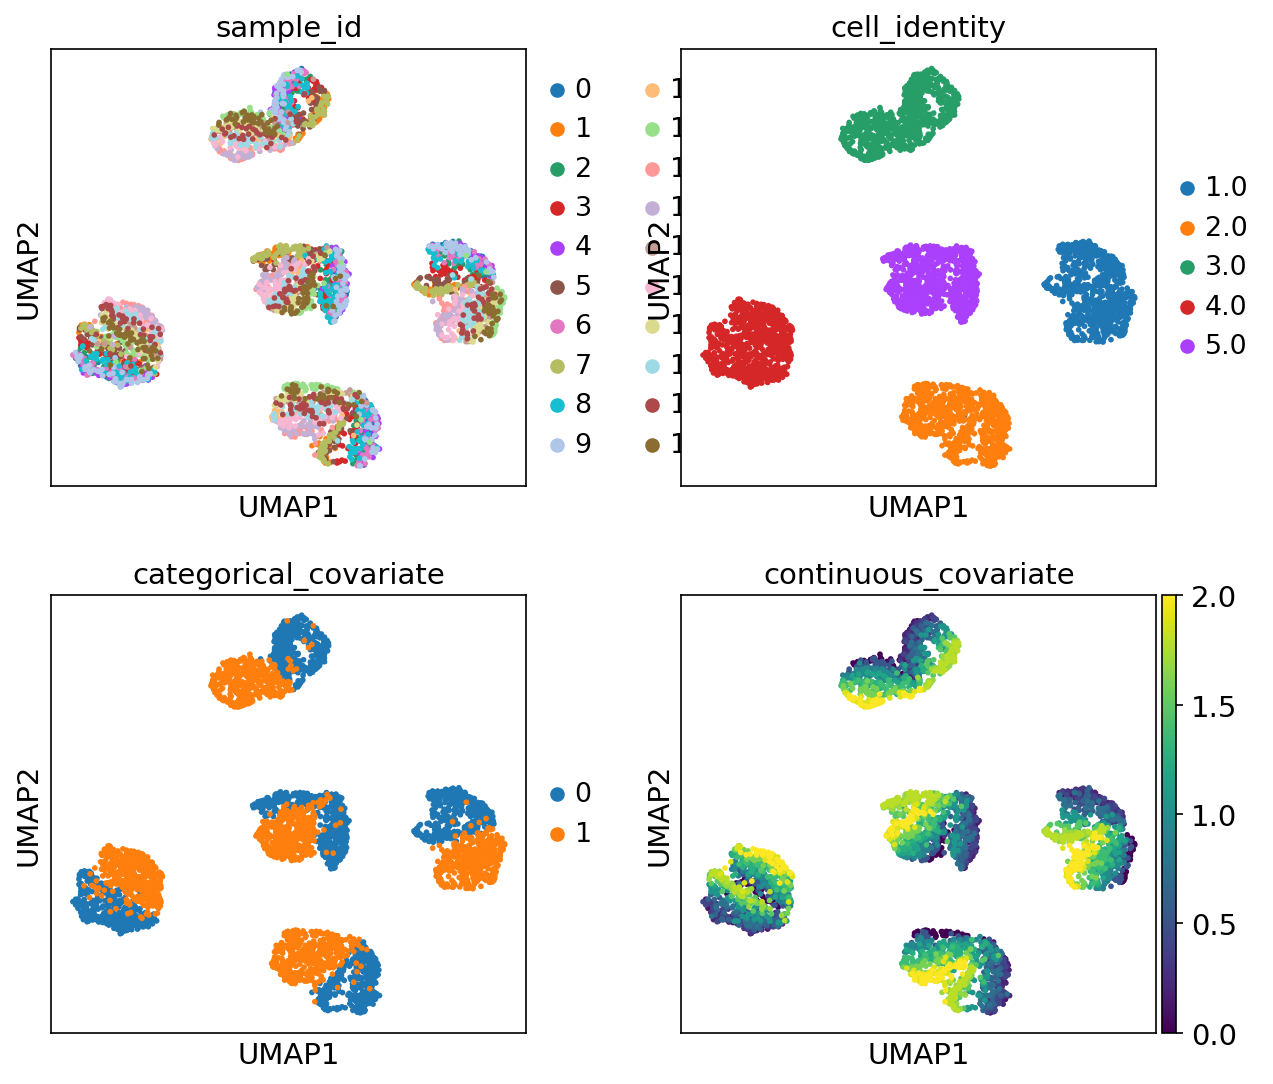

In [ ]:
# @markdown Variability in the cell population is driven by both a) cellular identity (unknown biological variability) and b)/c) sample identity. We assume that the sample-level metadata is known to the researcher (e.g. due to the specific experimental design etc.)
sc.pl.umap(
    adata, color=['sample_id', 'cell_identity',  'categorical_covariate', 'continuous_covariate'], ncols=2
)

### Dimensionality selection
Based on the scree plot, we can select 7 dimensions as the optimal dimensionality, which also happens to be the true dimensionality of the dataset

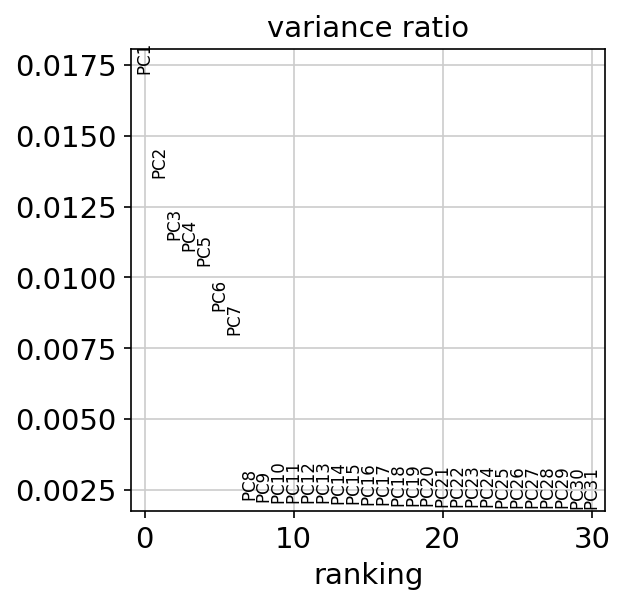

In [ ]:
sc.pl.pca_variance_ratio(adata)

### Modelling approach

Using principal component regression, we can estimate the relevance of covariates of interest and their influence on the single-cell expression.

We see that the `categorical_covariate` and `continuous_covariate` explain considerable amounts of variance in the first 50 principal components (4.7% and 6.7% respectively), while the random covariate explains close no variance in the data (0.1%). Based on this analysis, we select the categorical and continuous covariate for explicit modelling.

In [ ]:
pcr_explained_variance = dict()
for c in ['categorical_covariate', 'continuous_covariate', 'random_covariate']:
  pcr_explained_variance[c] = sccoral.tl.stats.principal_component_regression(adata, c, transform_categorical=True)

pcr_explained_variance

{'categorical_covariate': 0.04713955918944218,
 'continuous_covariate': 0.06719327443923483,
 'random_covariate': 0.0010576625108625205}

### Tuning

Normally, we would run a tuning procedure to select the ideal regularization strength or the linear decoder in the model. As this hyperparameter optimization takes a while, we will skip this step here and refer to the hyperparameter optimization tutorial and use the previously identified optimal value of

$$\alpha_{\text{l1}} = 1000$$

> **Note** While developing the model, we performed further hyperparameter tuning experiments and did not observe considerable improvements in the recovery of the gene loadings for
1.  Strength of the KL-divergence ($\beta$ parameter)
2. Dropout rate
3. Weight decay of Adam optimizer
4. Pretraining length
5. Length of warm-up strength
LSCVI-derived defaults worked well in our case.

### Run

We run the model with the basic scvi-tools syntax.


We would like to highlight some important parameters for sccoral:


**setup anndata/Covariate modeling**

1. `categorical_covariates`: Categorical covariates are encoded as one-hot encoodings for which sccoral learns the parameters of a normal distribution in a single latent dimension in the latent space.

2. `continuous_covariates`: For continuous covariates, sccoral learns a transformation that again predicts mean and standard deviation of a normal distribution in latent space.

3. `layer`: We use the raw count data, in line with the generative model of scvi


In [ ]:
# Set seed for reproducibility
scvi.settings.seed = 42
np.random.seed = 42
torch.manual_seed(42)

# Set anndata
sccoral.model.SCCORAL.setup_anndata(
    adata,
    categorical_covariates='categorical_covariate',
    continuous_covariates='continuous_covariate',
    layer='counts'
)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


**model**

The central parameters of the model are the number of latent factors (`n_latent`) and the regularization strength of the linear decoder (`alpha_l1`), which we determined during the preprocessing steps.


In [ ]:
# Setup model (5 latent dimensions + covariate dimensions)
# Regularization strength = 1000
model = sccoral.model.SCCORAL(
    adata, n_latent=5, alpha_l1=1000
)

**model.train**

The training procedure consists of two parts: First, we only train the decoder and the covariate-informed parts of the encoder, while freezing the gene-expression informed part of the encoder (*pretraining*). This pretraining procedure is necessary so that the covariate-informed dimensions are not caught in local, globally suboptimal minima. Per default, we run pretraining until the reconstruction loss on the validation set converges (or a maximal number of epochs of 500). Pretraining can be fully disabled (`pretraining=False`) or limited to a reduced number of epochs (`pretraining_max_epochs=XXX`).


The parameters for the training procedures are similar to the ones used in LSCVI. Smaller datasets require more epochs to converge.

In [ ]:
# Train model
model.train(max_epochs=2000)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 396/2000:  20%|█▉        | 395/2000 [02:53<10:16,  2.60it/s, v_num=1, train_loss_step=1.23e+3, train_loss_epoch=1.26e+3]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/callbacks/finetuning.py:233: The provided params to be frozen already exist within another group of this optimizer. Those parameters will be skipped.
HINT: Did you init your optimizer in `configure_optimizer` as such:
 <class 'torch.optim.adam.Adam'>(filter(lambda p: p.requires_grad, self.parameters()), ...) 


Epoch 1028/2000:  51%|█████▏    | 1028/2000 [07:31<07:06,  2.28it/s, v_num=1, train_loss_step=1.18e+3, train_loss_epoch=1.22e+3]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 1225.583. Signaling Trainer to stop.


Let us check whether the model has converged:

[Text(0.5, 0, '#Epoch'), Text(0, 0.5, 'Reconstruction loss\n(validation set)')]

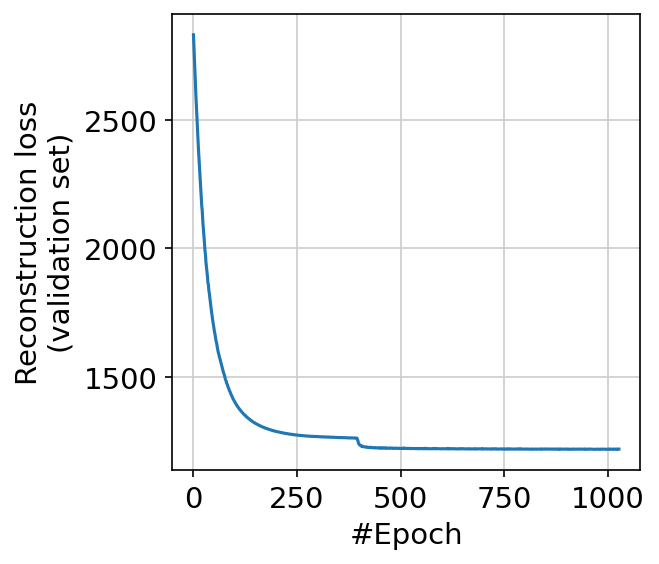

In [ ]:
# @markdown Hidden code
plt.plot(model.history['reconstruction_loss_validation'])
plt.gca().set(xlabel='#Epoch', ylabel='Reconstruction loss\n(validation set)')

### Evaluation

As a first step, we extract the learned a) cell-embeddings from the model, which we interpret as factor activities (`model.get_latent_representation()`)
and b) the weights of the linear decoder (`model.get_loadings()`) which represent the inferred gene loadings.

In [ ]:
# Assure that model is on cpu
model.module.cpu()
z = model.get_latent_representation()

loadings = model.get_loadings()

Now, let us visualize the inferred activity of the obtained factors.

We see that the latent space of the free factors 0, 1, ... 4 exhibits a bimodal distribution, which corresponds to our expectation based on the generative process from which the count data was simulated.

The categorical factor also captures the bimodality of the cell population and the distribution of the continuous factor aligns with the expected linear increase in the factor activity for this covariate

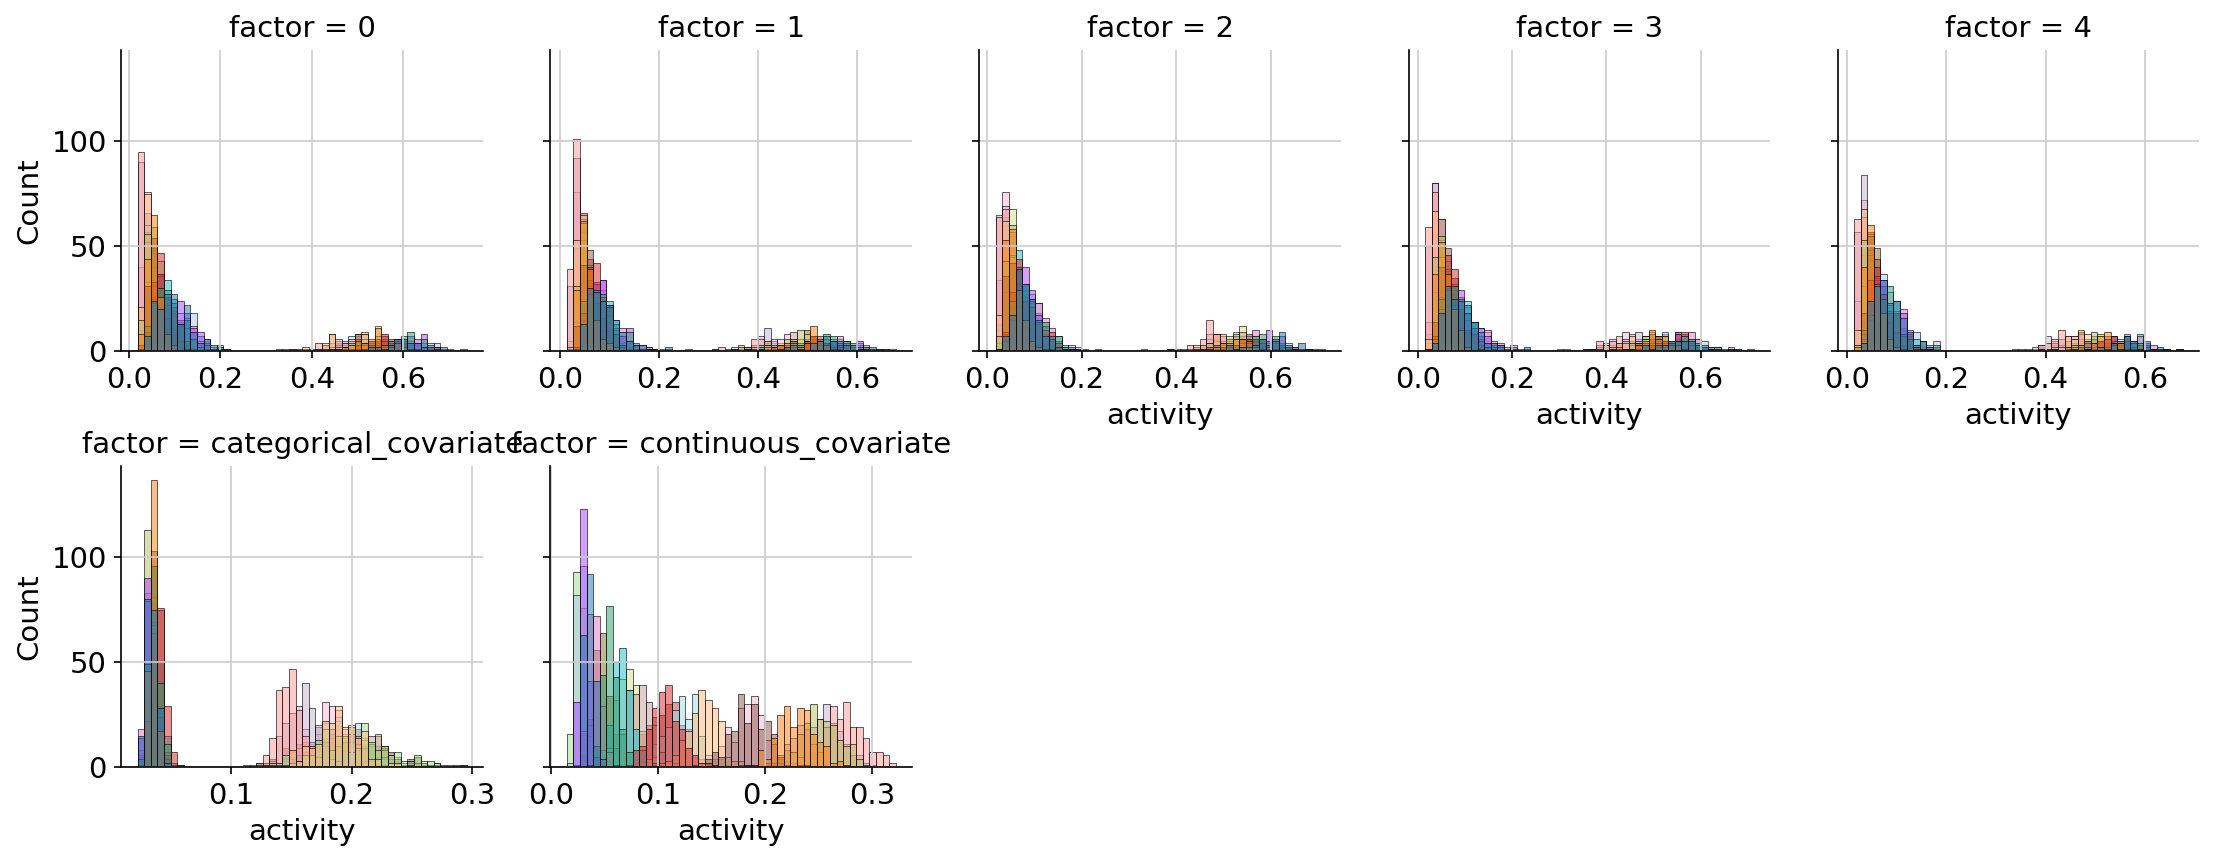

In [ ]:
# Plot representation
# Bring data in tidy-long format
data = z.melt(ignore_index=False, var_name='factor', value_name='activity')

# Plot with seaborn
g = sns.FacetGrid(data=data, col='factor', col_wrap=5, sharex=False)
g.map_dataframe(sns.histplot, x='activity', hue=adata.obs['sample_id'], bins=50)
plt.show()

Now we evaluate the faithfulness of the recovery by computing the correlation with the ground truth gene loadings (`adata.varm["program_loading"]`)

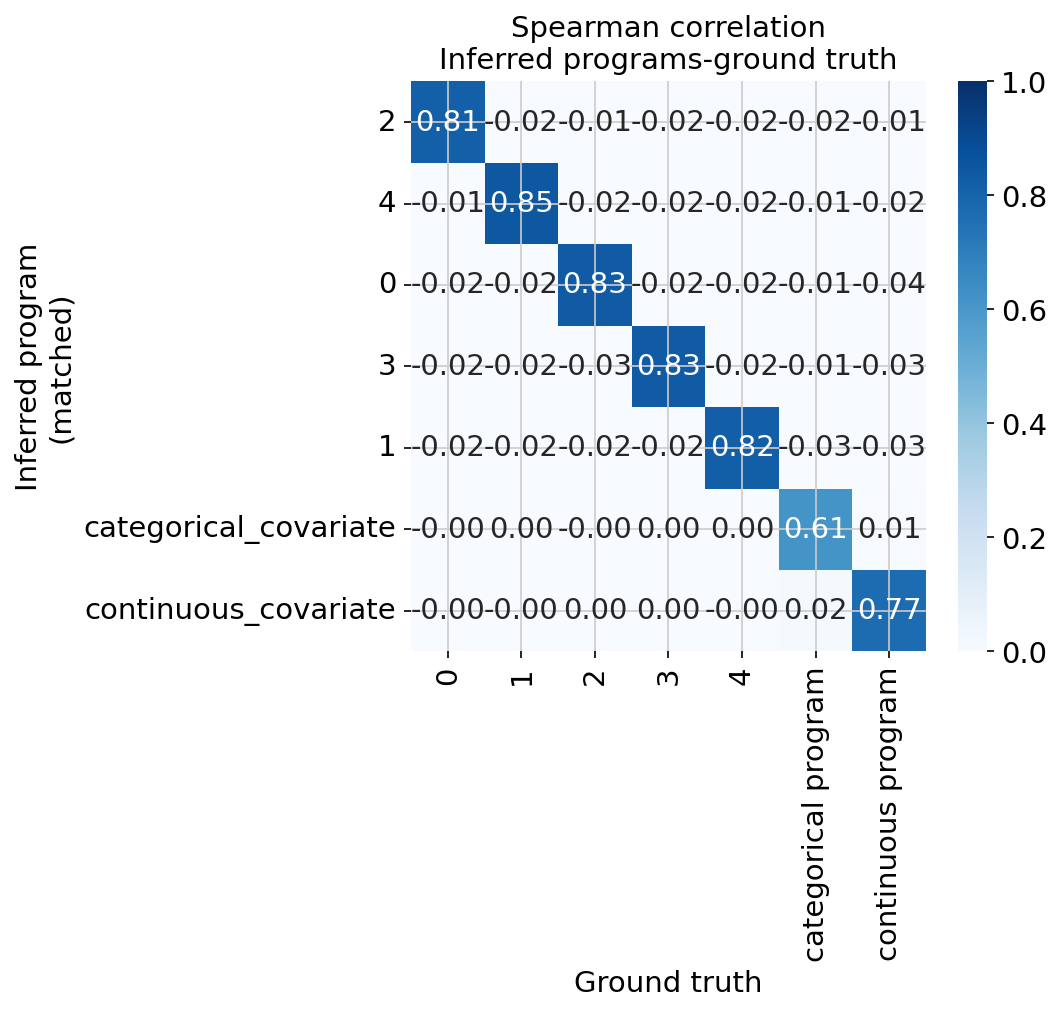

In [ ]:
ground_truth = pd.DataFrame(
    adata.varm["program_loading"],
    index=adata.var_names,
    columns=[0, 1, 2, 3, 4, 'categorical program', 'continuous program']
    )

similarity = compute_cosine_similarity(loadings, ground_truth)

fig, ax = plt.subplots(1, 1, figsize=(5.5, 5))
sns.heatmap(similarity, annot=True, fmt=".2f", cmap='Blues', vmin=0, vmax=1, ax=ax)
ax.set(title='Cosine similarity\nInferred programs-ground truth',
       ylabel='Inferred program\n(matched)',
       xlabel='Ground truth'
       )
plt.show()

We note that

1. The covariate-informed programs indeed capture the intended ground truth gene programs (i.e. the respective metadata-informed programs are highly correlated with the underlying ground truth programs).

2. All programs are matched with exactly 1 ground truth program and exhibit high correlation with this program

---

### References

[^1]: **Single-cell best practices**
Heumos, L., Schaar, A.C., Lance, C. et al. Best practices for single-cell analysis across modalities. Nat Rev Genet (2023). [https://doi.org/10.1038/s41576-023-00586-w](https://doi.org/10.1038/s41576-023-00586-w)

[^2]: **HVG selection**
Stuart T, Butler A, Hoffman P, Hafemeister C, Papalexi E, Mauck WM 3rd, Hao Y, Stoeckius M, Smibert P, Satija R. Comprehensive Integration of Single-Cell Data. Cell. 2019 Jun 13;177(7):1888-1902.e21. [doi: 10.1016/j.cell.2019.05.031.](https://doi.org/10.1016/j.cell.2019.05.031) Epub 2019 Jun 6. PMID: 31178118; PMCID: PMC6687398.

[^3]: **Kneedle algorithm** V. Satopaa, J. Albrecht, D. Irwin and B. Raghavan, "Finding a "Kneedle" in a Haystack: Detecting Knee Points in System Behavior," 2011 31st International Conference on Distributed Computing Systems Workshops, Minneapolis, MN, USA, 2011, pp. 166-171, doi: 10.1109/ICDCSW.2011.20.

[^4]: **scvi-tools** A Python library for probabilistic analysis of single-cell omics data. A. Gayoso*, R. Lopez*, G. Xing*, P. Boyeau, V. Valiollah Pour Amiri, J. Hong, K. Wu, M. Jayasuriya, E. Mehlman, M. Langevin, Y. Liu, J. Samaran, G. Misrachi, A. Nazaret, O. Clivio, C. Xu, T. Ashuach, M. Lotfollahi, V. Svensson, E. Beltrame, V. Kleshchevnikov, C. Talavera-Lopez, L. Pachter, F.J. Theis, A. Streets, M.I. Jordan, J. Regier, N. Yosef. Nature Biotechnology, 2022

[^5]: **scVI** Lopez R, Regier J, Cole MB, Jordan MI, Yosef N. Deep generative modeling for single-cell transcriptomics. Nat Methods. 2018 Dec;15(12):1053-1058. doi: 10.1038/s41592-018-0229-2. Epub 2018 Nov 30. PMID: 30504886; PMCID: PMC6289068.

[^6]: **Linear scVI** Valentine Svensson, Adam Gayoso, Nir Yosef, Lior Pachter, Interpretable factor models of single-cell RNA-seq via variational autoencoders, Bioinformatics, Volume 36, Issue 11, June 2020, Pages 3418–3421, https://doi.org/10.1093/bioinformatics/btaa169

